<h1>Wafer Unsupervised Clusters Report</h1>
<h2> taking a look at the data </h2>
since the wafer data didn't have any preview, I needed to take a look at the data first.
After unpickling the data, I took a look at the columns of data which were noted to be:

- waferMap
- dieSize
- lotName
- waferIndex
- trianTestLabel 
- failureType

with the defect catagories to be defined as: 
- Center
- Donut
- Edge-Loc
- Edge-Ring
- Loc
- Random
- Scratch
- Near-full
- none

The feature which was deemed as the most important was the wafermap while the other features didn't
seem as important for the primary task of being able to seperate the wafer defect catagories into
clusters. There didn't seem to be a need for any segmentation as the data is already segmentated representation of
the empty space, defect region, and good region.
<br>



<h2>Main Idea</h2>
Given that the task was to make an unsupervised clustering,The main goal I had in mind was to make
a clustering that would be convex and seperated from each other. The first task was to make a 
pipeline with the steps of:

- data processing
- dimension reduction
- unsupervised cluster (picked k-means)

Thus the most important step was deemed to be the data processing and dimension reduction to have 
a seperated dataset similar to how the mnist was able to be seperated. 

<h3>Preprocessing</h3>

Even though the processing of data wasn't the first thing to consider, there was some observations.
The first observation was how the wafer maps weren't of the same dimension. The wafer dimension
needed to be standardized in order to be able to use a dimension reduction which is why I used
a resize to get all the wafer maps to be the same size.
<br>

The second observation was that the wafer map appeared to have salt and pepper noise. Thus I used
a 3 by 3 median filter as using a larger one would run the risk of destroying the representation
of the random catagory of wafer defects. 
<br>

The third observation came after the dimension reduction representation didn't result in expected
results of having the clusters seperate. The observation was the radial nature of the wafers which
could be an issue as a edge ring defect could be centered on any part of the disk. Thus the idea
was to rotate all the images so that the defect region would be centered at the bottom in order
to make the representation easier. 
<br>

The fourth observation is that the none catagory had issues of having a consistant representation.
it was noted that the none catagory seemed to have the issue of denoising not removing every part
of the noise as some defective regions are still present. This has to be balanced with the median
filter to not remove the random catagory defect. 
<br>

The fifth observation was to collapse the good region and the non-wafer region to focus on the
binary defect vs everything else.

<h3>Dimension Reduction</h3>
when considering the dimension reduction, UMAP was picked as the wafer map representation didn't
appear to be something that would work well with PCA which is an eigenvector linear representation
and the difference between edge ring and loc didn't seem to be a linear relation.

The difference was that compared to the easier mnist dataset, the defects appeared to always collapse
into one cluster while the none catagory would be nonconvex. Thus the first idea to address the issue
was to pursue further pre-processing of the wafer map data which resulted in the median filter and
wafer rotation ideas. After those ideas didn't work as expected, the UMAP documentation of metric
learning by utilizing the label data for the clustering was used on the training subset in order to
observe if a better representation could be found.

<h3>Clustering</h3>
The naive pick of just using K-Means over GMM or DBSCAN was chosen as the expected challange was in the
dimension reduction and data processing.


Results:
based on the results of the test data, it appears that the metric learning using the training labels 
doesn't appear to get very much useful information from the metric learning and the problem appears
to collapse between the non-defective and defective cases for the test data umap not using the 
labels.

a decent result is that the non-defect cases representation collapse from removing the wafer and
non-wafer difference still remains. Thus I would deem that the clustering is primarily useful only
for clustering between defective and non-defective wafers.


In [2]:
# import numpy, pandas, sklearn for k-means and pca


import numpy as np
import pandas as pd
import sklearn
import pickle
import matplotlib.pyplot as plt
import umap
import cv2


import collections

from scipy import ndimage
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
#from sklearn.datasets import load_digits

In [3]:

# #debug test (seems like the shape of the data is wrong)
# digits = load_digits()
# print(digits.data,digits.data.shape)
# model = umap.UMAP()
# embedding = model.fit_transform(digits.data)

# plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
# plt.title('UMAP projection of the Digits dataset', fontsize=24);

In [4]:
# import the data from pickle
src = "./data/LSWMD.pkl"
data=pd.read_pickle(src)


# clean the label data as I would be using it for getting a subset
def clean(x):
    if(len(x) == 0):
        return ""
    else:
        return x[0][0]

def replacecolumn(column):
    newcolumn = []
    for entry in column:
        if(len(entry)==0):
            entry = ""
        else:
            entry = entry[0][0]
        newcolumn.append(entry)
    return newcolumn

collabel = replacecolumn(data["trianTestLabel"])
colfailuretype = replacecolumn(data["failureType"])

data["trianTestLabel"] = collabel
data["failureType"] = colfailuretype

# clean unlabeled data
print(data.shape)
data = data[data["failureType"] != ""]
print(data.shape)


(811457, 6)
(172950, 6)


ideas jotted down.

first the simplest model would be to try to see if the data is linearly seperable. 
So the first thing to try is to see 2d projections of the data to see if they is some inherent clusters.
<br>

since the task is to find an unsupervised method to cluster even though the data seems to be supervised.
The most naive way would be to try K-means or EM in order to cluster. Since the clustering requires a known number of clusters, the naive way was to use the number of clusters as failure types. 
<br>

seems like the wafer map is an image so a CNN might be needed. that doesn't make sense as that is going the supervised learning route.

what about segmentation of the wafer map? that doesnt make sense as the wafermp is already essentially a segmentation map.

given the idea about rotations, it might be a good idea to preprocess the data to find the maximal amount of issues at the bottom half plane to standardize all the circular defects.

The rotation seems to be able to start to unravel the central defect cluster.


In [5]:
print(data["trianTestLabel"][0])
print(data.columns)

Training
Index(['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel',
       'failureType'],
      dtype='object')


In [6]:
# debugging dataframe
#for index, row in data.iterrows():
   #print(index)
print(data["trianTestLabel"][800000],data["failureType"][800000]) #[0],entry[2].shape,entry[5],entry[7],entry[9],entry[13])
#    print("\n") 

Test none


the columns of the data are 'waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel',
       'failureType'
       
size of the wafer is a consistant 2160 size and 45 by 48 shape. (wrong assumption!!!)

need to fetch an example of each type of defect 


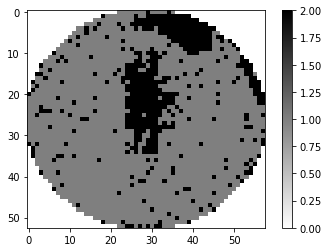

(53, 58) Loc Training


In [7]:
num = 40
# 38(edge-loc),40(loc),44(center),46(none), 161(), 186(edge-ring)
a = data["waferMap"][num]
b = data["failureType"][num]
c = data["trianTestLabel"][num]
plt.imshow(a, cmap='binary', interpolation='nearest')
plt.colorbar()
plt.show()
print(a.shape,b,c)




based on the cell it seems like a good wafer is all zeros

edge-loc seems to be both 


it seems like the cluster space for some cases is not linear. Thus PCA wouldn't be a good represenation either as it depends on linear eigenvalues.
<br>
maybe they could be a meaningful cluster representation of using U-Map or tsne which are non-linear embeddings

The noise looks like salt and pepper which means need a median filter.
<br>

the wafers are of different sizes

In [8]:
# use the training data as using the whole data set is costly and results in kernel crash.
subdata = data[data['trianTestLabel'] == "Training"] #data cleaning of [["Training"]]-> "Training" needed

#check only defective ones as the defects are in one cluster
#subdata = subdata[data['failureType'] != "none"] #data cleaning of [["Training"]]-> "Training" needed

# fetch the wafer map and failure type
waferdata = subdata["waferMap"]
labelwaferdata = subdata["failureType"]

lb_make = LabelEncoder()
labelwaferdata = lb_make.fit_transform(labelwaferdata)
print(labelwaferdata[0])

# the idea is to have all the circular defects be close to the normal by making any defect at the edge to be rotated to be at the bottom
def rotationmax(wafer):
    rotationlist = []
    rotangle = 60 # having a degree of not 90 results in more empty space which can be resolved with 
    steps = 360//rotangle
    for i in range(steps):
        rotated = ndimage.rotate(wafer, rotangle*i, reshape=False)
        rotationlist.append(rotated)
    
    
    intensitylist = []
    for image in rotationlist:
        #3*(len(a)//4):len(a),:
        intensitysum = sum(sum(image[1*(size[1]//2):size[1],:]))
        intensitylist.append(intensitysum)
    
    idx = np.argmax(intensitylist)
    
    #print(len(rotationlist),idx,steps,intensitylist)

    newwafer = rotationlist[idx]
    
    return newwafer
    
# resize the wafer maps to be uniform

size = (51,51)
thresh = 1.5

newwaferdata = []
for idx,wafer in enumerate(waferdata):
    wafer = cv2.medianBlur(wafer, 5)
    wafer = cv2.medianBlur(wafer, 3)
    wafer = cv2.resize(wafer, dsize=size, interpolation=cv2.INTER_CUBIC)

    #wafer = cv2.medianBlur(wafer, 3)
    wafer = rotationmax(wafer)
    wafer = cv2.threshold(wafer, thresh, 255, cv2.THRESH_BINARY)[1]    
    #print(wafer.shape)
    #wafer = np.array(wafer).reshape(size[0]*size[1])
    newwaferdata.append(wafer)

newwaferdata = np.array(newwaferdata)
print(newwaferdata.shape,newwaferdata[0].shape)
   
# rotations need to happen to every image as the label data isn't known.

8
(54355, 51, 51) (51, 51)


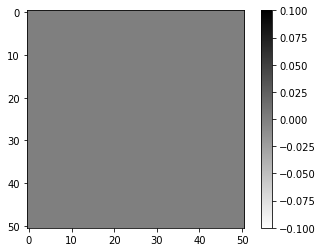

(51, 51) none


In [9]:
num = 105
# 38(edge-loc),40(loc),44(center),46(none), 161(), 186(edge-ring), 811427(scratch), 811448(Edge-Ring)
a = newwaferdata[num]
label = lb_make.inverse_transform(labelwaferdata)[num]
#c = subdata["waferIndex"][num]
plt.imshow(a, cmap='binary', interpolation='nearest')
#plt.imshow(a[3*(len(a)//4):len(a),:], cmap='binary', interpolation='nearest') #error in rotations
plt.colorbar()
plt.show()
print(a.shape, label)

#the median filter removed the salt and pepper noise
# edge ring seems to lose form under the 5 median filter
# the rotation for 90 degrees seems to work
# the none wafer map has some unresolved edges for median filter 3 by 3 (what about trying two passes instead of a larger one)

In [10]:
##### umap
length = newwaferdata.shape[0]
#print(type(waferarr), waferarr[200].shape)
#waferdata.shape = (length, -1) #np.array(waferdata).reshape((length,size[0]*size[1]))


flatnewwaferdata = newwaferdata.reshape((length,size[0]*size[1]))

print(flatnewwaferdata,flatnewwaferdata.shape)
#print(umap)
model = umap.UMAP(
    n_neighbors=40,
    min_dist=0.0,
    n_components=2,
    random_state=42
)
umapdata = model.fit_transform(flatnewwaferdata, y = labelwaferdata)
umapdata.astype("double")
#811456
# try a subset, which means the test set would be useful to fetch the subset while having each type of wafer

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (54355, 2601)


array([[-6.78770542e+00,  1.35613531e-01],
       [-6.47782087e+00,  2.01095724e+00],
       [-5.73900414e+00,  9.76158738e-01],
       ...,
       [-5.87135935e+00,  3.94594343e-03],
       [-8.30857944e+00,  3.94548774e-01],
       [-6.85708809e+00,  2.35512614e+00]])

['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'none']
Counter({'black': 36730, 'green': 8554, 'red': 3462, 'yellow': 2417, 'blue': 1620, 'cyan': 609, 'purple': 500, 'orange': 409, 'lime': 54})
Counter({'none': 36730, 'Edge-Ring': 8554, 'Center': 3462, 'Edge-Loc': 2417, 'Loc': 1620, 'Random': 609, 'Scratch': 500, 'Donut': 409, 'Near-full': 54})


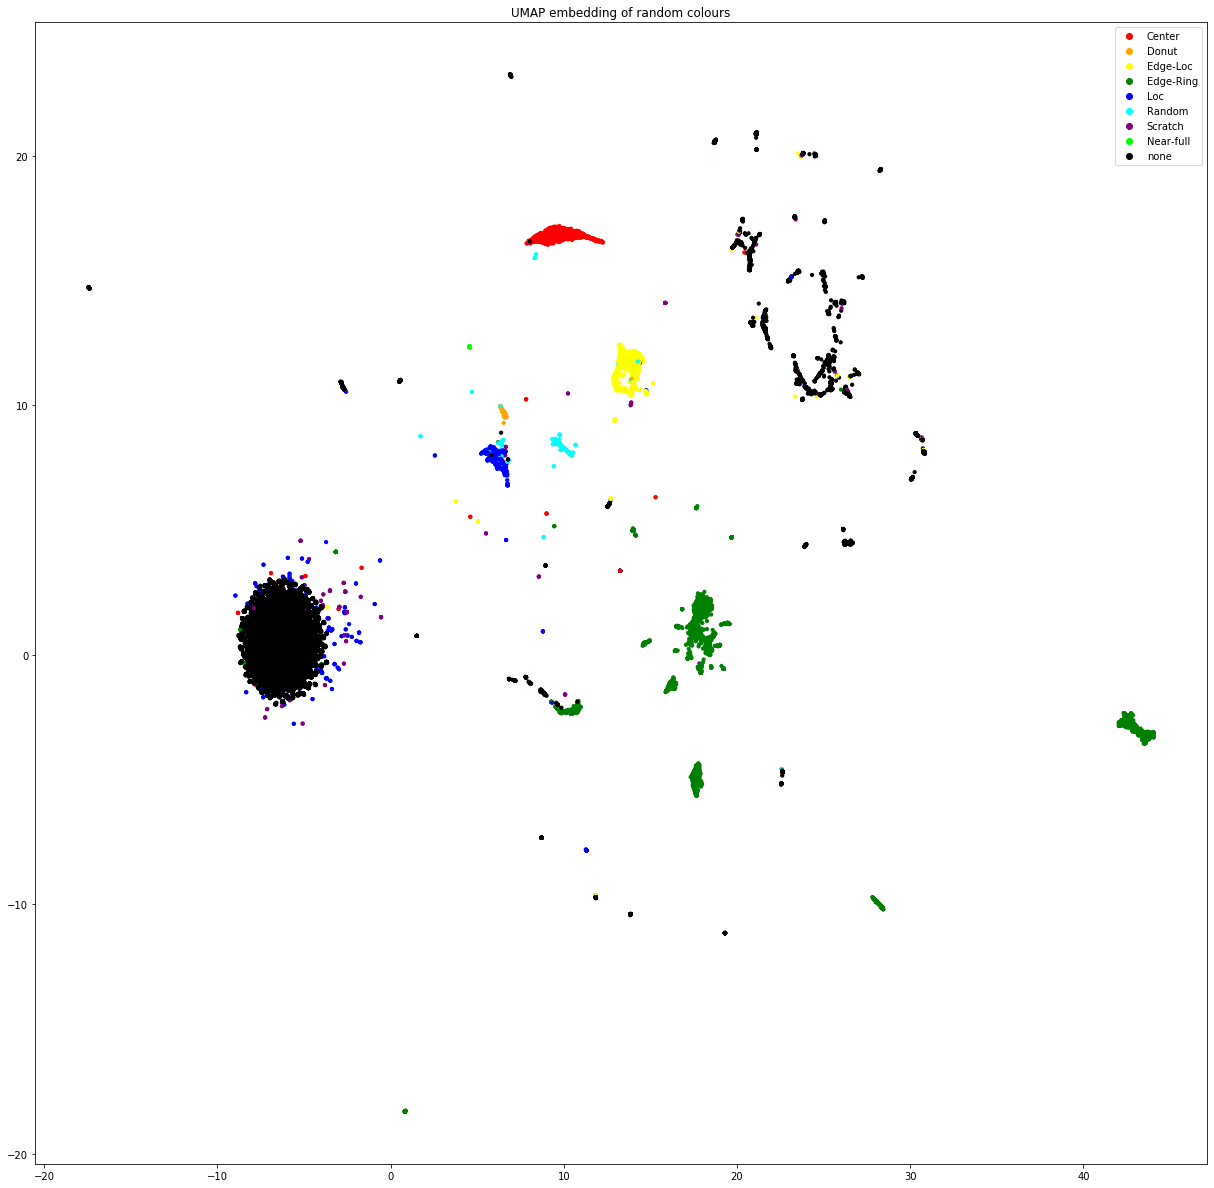

In [11]:
#Center, Donut, Edge-Loc, Edge-Ring, Loc, Random, Scratch, Near-full, none.
import matplotlib.patches as mpatches

classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Random", "Scratch", "Near-full","none"]


colormap = {
    "Center"   : "red",
    "Donut"    : "orange",
    "Edge-Loc" : "yellow",
    "Edge-Ring": "green",
    "Loc"      : "blue",
    "Random"   : "cyan",
    "Scratch"  : "purple",
    "Near-full": "lime",
    "none"     : "black"
}

colors = subdata["failureType"].map(colormap)

#classes = list(set(lb_make.inverse_transform(labelwaferdata)))
print(classes)
print(collections.Counter(colors))
print(collections.Counter(subdata["failureType"]))


plt.figure(figsize=(21, 21))
scatter = plt.scatter(umapdata[:,0], umapdata[:,1], c=colors,s=10.1) #,label=str(classes))
plt.title('UMAP embedding of random colours')


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colormap.values()]
plt.legend(markers, colormap.keys(), numpoints=1)

plt.show()
#the clustering doesn't seem promising for finding data behavior for 16 by 16 as it probably lost too many features.
# maybe having a higher n-neighbors is needed for a global structure compared to mnist
# maybe needs a radial representation. 
# using the labels seems to be helpful.
# experiment between global and local features with n_neighbors. (best result is for )

In [12]:
# k-means
# because of the catagories, assume 9 clusters



kmeans = KMeans(n_clusters=9, random_state=0)
clusters = kmeans.fit_transform(umapdata)

# reminded of dbscan as another clustering method
# might need to run multiple kmeans then pick based on the best metric as random starting points could backfire.

[[16.424767  -0.8115008]
 [-6.259542   0.5702977]
 [ 9.774035  16.861496 ]
 [26.681116   8.552749 ]
 [43.21698   -3.0309136]
 [22.892649  16.568192 ]
 [ 5.6113443  8.695119 ]
 [13.513155  10.921655 ]
 [26.669802  -9.315455 ]]
KMeans(n_clusters=9, random_state=0)
float32
float32 float32


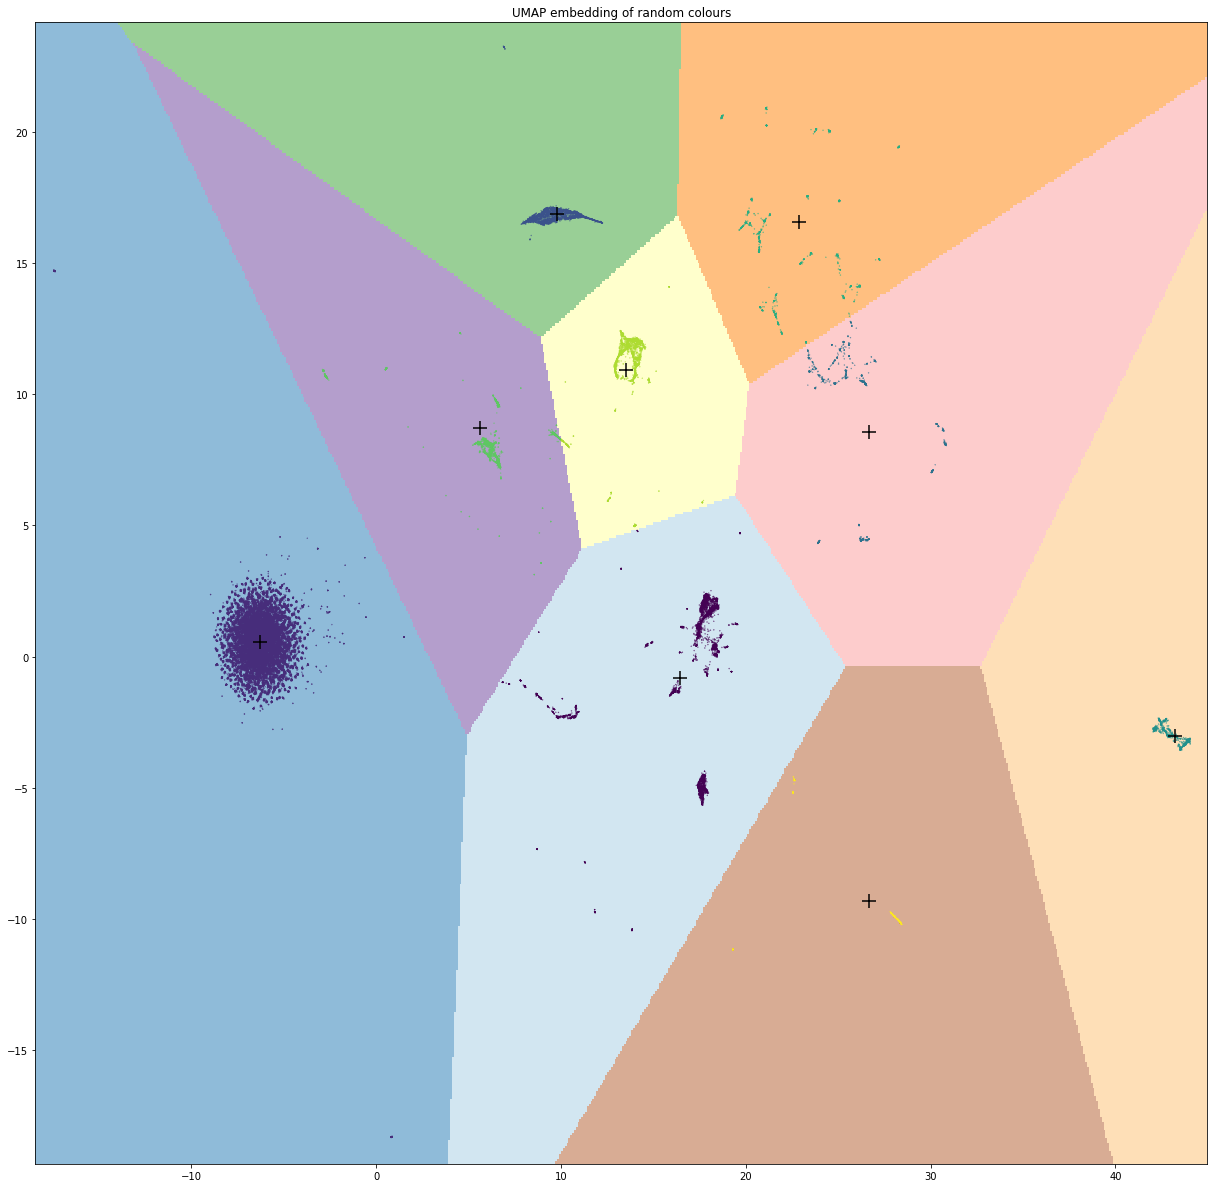

In [13]:
#kmeans plotting


centers = kmeans.cluster_centers_
print(centers)
print(kmeans)
print(umapdata.dtype)

plt.figure(figsize=(21, 21))

umapdata = np.array(umapdata, dtype=np.float32)

#mesh
h = 0.1     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = umapdata[:, 0].min() - 1.0, umapdata[:, 0].max() + 1.0
y_min, y_max = umapdata[:, 1].min() - 1.0, umapdata[:, 1].max() + 1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

xx = np.array(xx, dtype=np.float32)
yy = np.array(yy, dtype=np.float32)

print(xx.dtype,yy.dtype)

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower", alpha = 0.5)


#data and centroids
plt.scatter(umapdata[:,0], umapdata[:,1],c = kmeans.labels_, s = 0.1) #, c=newwaferdata)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=1.0,marker="+")
plt.title('UMAP embedding of random colours');
plt.show()

In [14]:
# #hdbscan
# import hdbscan
# import seaborn as sns
# print(umapdata.shape)
# clustermodel = hdbscan.HDBSCAN(min_cluster_size=50)
# clusterer =clustermodel.fit(umapdata)
# print(max(clusterer.labels_))
# color_palette = sns.color_palette('deep', max(clusterer.labels_) + 1)
# cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
# cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
# plt.figure(figsize=(21, 21))
# plt.scatter(umapdata[:,0], umapdata[:,1], s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

<h1>test the data </h1>

In [35]:
# use test data
testsubdata = data[data['trianTestLabel'] == "Test"]

# fetch the wafer map and failure type
testwaferdata = testsubdata["waferMap"]
#testlabelwaferdata = testsubdata["failureType"]

#lb_make = LabelEncoder()
#testlabelwaferdata = lb_make.fit_transform(labelwaferdata)
#print(testlabelwaferdata[0])


size = (51,51)
testnewwaferdata = []
for idx,wafer in enumerate(testwaferdata):
    wafer = cv2.medianBlur(wafer, 5)
    wafer = cv2.medianBlur(wafer, 3)
    wafer = cv2.resize(wafer, dsize=size, interpolation=cv2.INTER_CUBIC)

    #wafer = cv2.medianBlur(wafer, 3)
    wafer = rotationmax(wafer)
    wafer = cv2.threshold(wafer, thresh, 255, cv2.THRESH_BINARY)[1]    
    #print(wafer.shape)
    #wafer = np.array(wafer).reshape(size[0]*size[1])
    testnewwaferdata.append(wafer)

testnewwaferdata = np.array(testnewwaferdata)
print(testnewwaferdata.shape,testnewwaferdata[0].shape)

(118595, 51, 51) (51, 51)


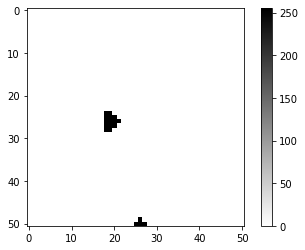

(51, 51)


In [36]:
num = 11
# 38(edge-loc),40(loc),44(center),46(none), 161(), 186(edge-ring), 811427(scratch), 811448(Edge-Ring)
a = testnewwaferdata[num]
#label = lb_make.inverse_transform(labelwaferdata)[num]
#c = subdata["waferIndex"][num]
plt.imshow(a, cmap='binary', interpolation='nearest')
#plt.imshow(a[3*(len(a)//4):len(a),:], cmap='binary', interpolation='nearest') #error in rotations
plt.colorbar()
plt.show()
print(a.shape) #, label)

In [37]:
# transform data
testlength = testnewwaferdata.shape[0]
flattestnewwaferdata = testnewwaferdata.reshape((testlength,size[0]*size[1]))

testumapdata = model.transform(flattestnewwaferdata)

['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'none']
Counter({'black': 110701, 'yellow': 2772, 'blue': 1973, 'green': 1126, 'red': 832, 'purple': 693, 'cyan': 257, 'orange': 146, 'lime': 95})
Counter({'none': 36730, 'Edge-Ring': 8554, 'Center': 3462, 'Edge-Loc': 2417, 'Loc': 1620, 'Random': 609, 'Scratch': 500, 'Donut': 409, 'Near-full': 54})


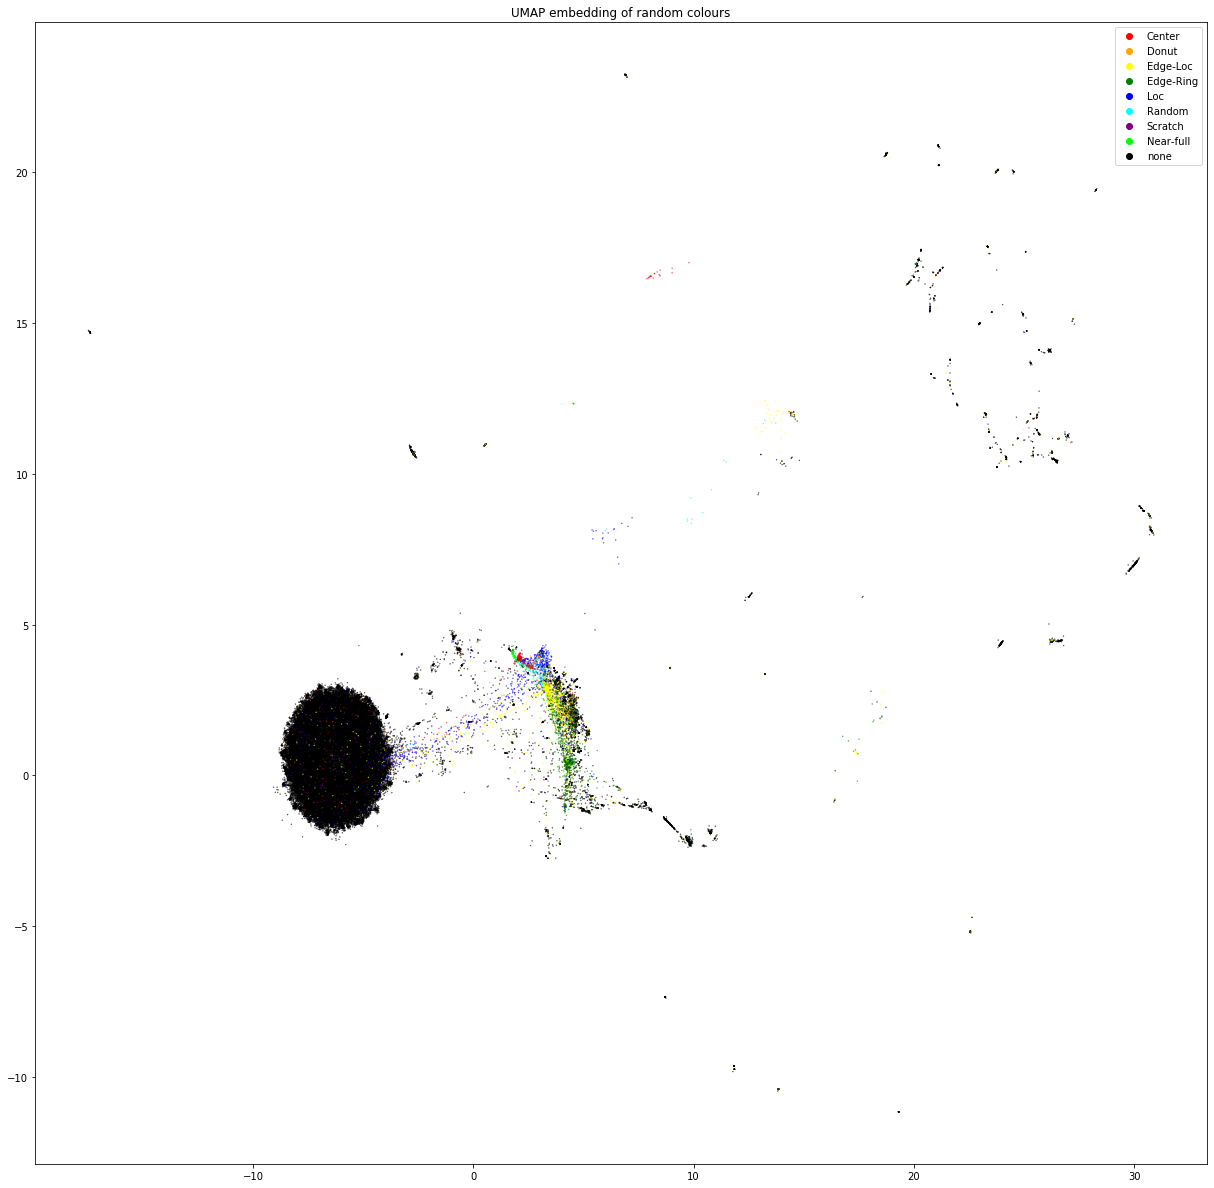

In [39]:
import matplotlib.patches as mpatches

classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Random", "Scratch", "Near-full","none"]


colormap = {
    "Center"   : "red",
    "Donut"    : "orange",
    "Edge-Loc" : "yellow",
    "Edge-Ring": "green",
    "Loc"      : "blue",
    "Random"   : "cyan",
    "Scratch"  : "purple",
    "Near-full": "lime",
    "none"     : "black"
}

colors = testsubdata["failureType"].map(colormap)

#classes = list(set(lb_make.inverse_transform(labelwaferdata)))
print(classes)
print(collections.Counter(colors))
print(collections.Counter(subdata["failureType"]))


plt.figure(figsize=(21, 21))
scatter = plt.scatter(testumapdata[:,0], testumapdata[:,1], c=colors,s=0.1) #,label=str(classes))
plt.title('UMAP embedding of random colours')


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colormap.values()]
plt.legend(markers, colormap.keys(), numpoints=1)

plt.show()

In [48]:
# k-means
# because of the catagories, assume 9 clusters

kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_transform(testumapdata)

[[23.61416446 10.84180079]
 [-5.17718488  0.76514115]]
KMeans(n_clusters=2, random_state=0)
float64
float64 float64


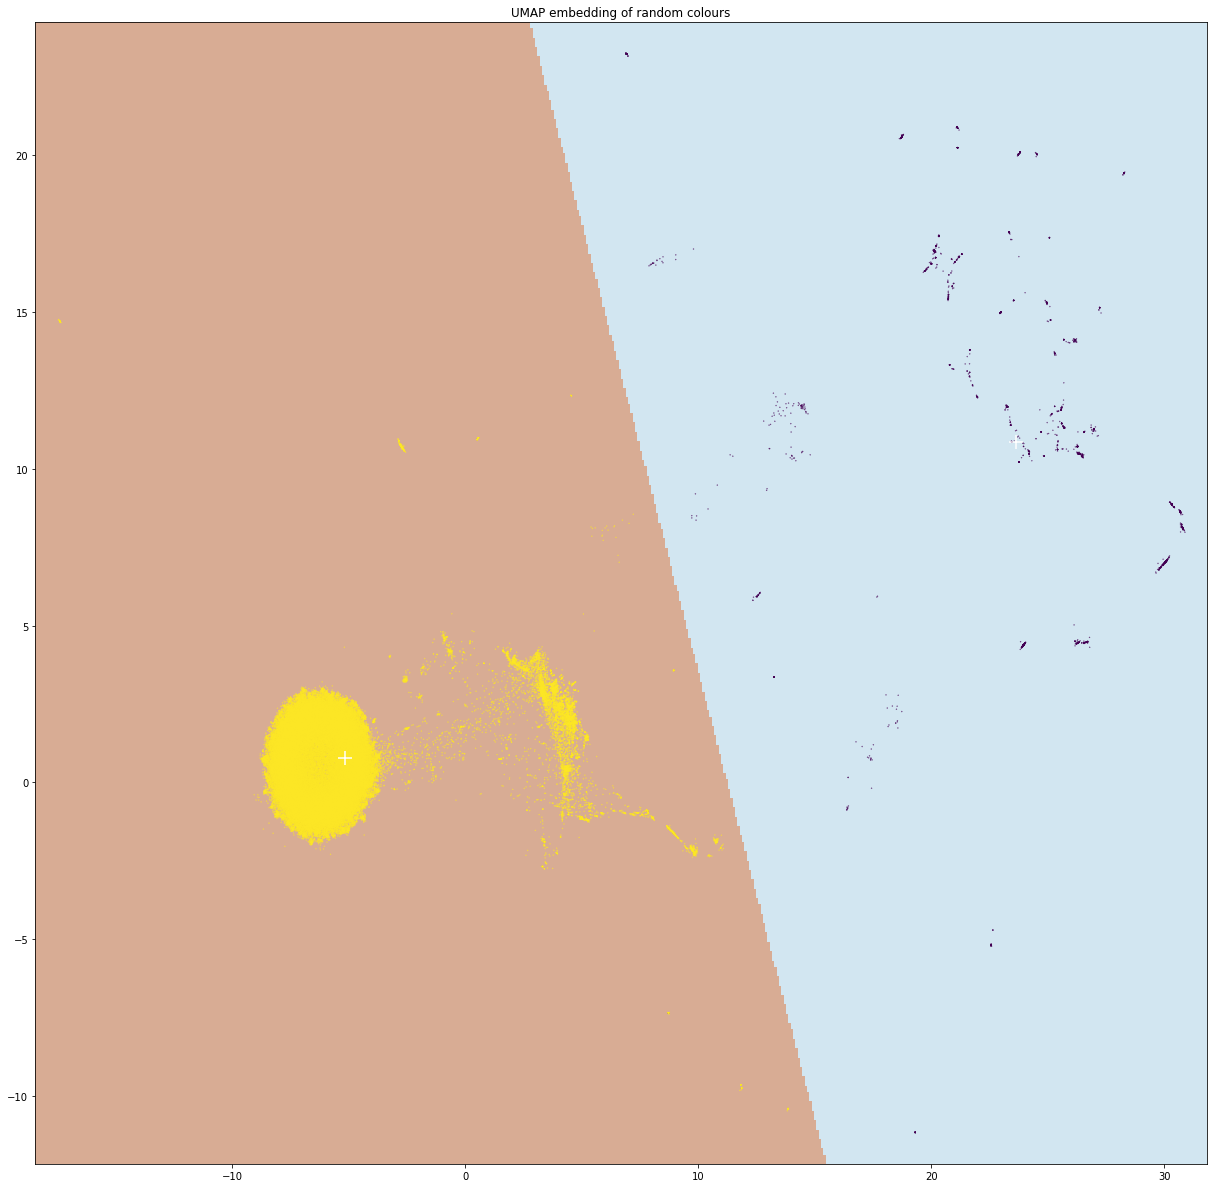

In [49]:
#plot results

centers = kmeans.cluster_centers_
print(centers)
print(kmeans)
print(testumapdata.dtype)

plt.figure(figsize=(21, 21))

testumapdata = np.array(testumapdata, dtype=np.float64)

#mesh
h = 0.1     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = testumapdata[:, 0].min() - 1.0, testumapdata[:, 0].max() + 1.0
y_min, y_max = testumapdata[:, 1].min() - 1.0, testumapdata[:, 1].max() + 1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

xx = np.array(xx, dtype=np.float64)
yy = np.array(yy, dtype=np.float64)

print(xx.dtype,yy.dtype)

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower", alpha = 0.5)


#data and centroids
plt.scatter(testumapdata[:,0], testumapdata[:,1],c = kmeans.labels_, s = 0.1) #, c=newwaferdata)
plt.scatter(centers[:, 0], centers[:, 1], c='white', s=200, alpha=1.0,marker="+")
plt.title('UMAP embedding of random colours');
plt.show()

sources used
https://docs.python.org/3/library/pickle.html
https://stackoverflow.com/questions/33127866/how-to-pickle-and-unpickle


error with pickle
https://stackoverflow.com/questions/37371451/importerror-no-module-named-pandas-indexes

dacs for dataframe
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html


https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas


the wafermap needs visualization of a heat map
https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib

check umap representation: https://umap-learn.readthedocs.io/en/latest/

get the pandas dataframe row to numpy for umap to work https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.to_numpy.html
https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe

rescale wafermap
https://stackoverflow.com/questions/48121916/numpy-resize-rescale-image

https://stackoverflow.com/questions/9057379/correct-and-efficient-way-to-flatten-array-in-numpy-in-python


fix shape issue
https://stackoverflow.com/questions/48823400/pandas-series-to-2d-array
https://towardsdatascience.com/get-into-shape-14637fe1cd32
https://stackoverflow.com/questions/40824601/how-to-convert-a-series-of-arrays-into-a-single-matrix-in-pandas-numpy


median filter
https://medium.com/@florestony5454/median-filtering-with-python-and-opencv-2bce390be0d1 
https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html


sklearn k-means

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

dataframe fetch test subset
https://stackoverflow.com/questions/36307609/how-can-i-select-data-from-a-table-with-specific-attribute-with-pandas 
https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/03_subset_data.html

dataframe reading bug (might need to use apply)
https://www.kite.com/python/answers/how-to-modify-all-the-values-in-a-pandas-dataframe-column-in-python

slowness in apply
https://stackoverflow.com/questions/38697404/pandas-explanation-on-apply-function-being-slow
https://ys-l.github.io/posts/2015/08/28/how-not-to-use-pandas-apply/


AttributeError: 'NNDescent' object has no attribute 'neighbor_graph'
https://github.com/lmcinnes/umap/issues/403 (seems like enviroment issues)
<br>

jupyter lab is the new thing.

<br>
fix package llvmlight https://github.com/NVIDIA/NeMo/issues/841

needed bigger plot: https://stackabuse.com/change-figure-size-in-matplotlib/
needed smaller points: https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size
need interactive plot: 

The report seems to suggest not having a label means that particular point of data might be trash data. 
https://www.kaggle.com/ashishpatel26/wm-811k-wafermap

umap for clustering: https://umap-learn.readthedocs.io/en/latest/clustering.html
nicer plots: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html


TypeError: create_target_machine() got an unexpected keyword argument 'jitdebug':
https://github.com/mkocabas/VIBE/issues/91
https://github.com/lmcinnes/umap/issues/209 (numba issue)
https://github.com/numba/numba/issues/5600 (dependancy cascade for numba)


image rotation:
https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point


change resize (might need different interpolation based if image is bigger or smaller)
https://stackoverflow.com/questions/23853632/which-kind-of-interpolation-best-for-resizing-image

metric learning
https://umap-learn.readthedocs.io/en/latest/supervised.html
https://jlmelville.github.io/uwot/metric-learning.html


ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'
https://www.kaggle.com/zalando-research/fashionmnist (need to convert to numbers ex "Edge-Ring" = 1
https://www.codegrepper.com/code-examples/python/how+to+convert+labels+to+numbers+in+python(label encoder)


data labels
https://stackoverflow.com/questions/32236046/add-a-legend-to-my-heatmap-plot
https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html
https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/
https://stackoverflow.com/questions/31303912/matplotlib-pyplot-scatterplot-legend-from-color-dictionary

handling roatations that aren't 90 degrees
https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions

needed colormap to have a scale of wafermaps
https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib

thought about linearity of different convolutions.
https://dsp.stackexchange.com/questions/7875/median-filter-one-after-another
https://homepages.inf.ed.ac.uk/rbf/HIPR2/median.htm (one large median vs multiple median passes)


Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.
https://github.com/lmcinnes/umap/issues/90

ValueError: eigh has failed in lobpcg iterations


UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
https://www.biostars.org/p/259188/

hdbscan
https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

idea of collapsing representation to binary image
https://stackoverflow.com/questions/7624765/converting-an-opencv-image-to-black-and-white

dependancies in conda used.

_anaconda_depends         2019.10                  py37_0  
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
_libgcc_mutex             0.1                        main  
_pytorch_select           0.2                       gpu_0  
absl-py                   0.8.1                    pypi_0    pypi
alabaster                 0.7.12                   py37_0  
anaconda                  custom                   py37_1  
anaconda-client           1.7.2                    py37_0  
anaconda-navigator        2.0.3                    py37_0  
anaconda-project          0.8.3                      py_0  
asn1crypto                0.24.0                   py37_0  
astor                     0.8.0                    pypi_0    pypi
astroid                   2.2.5                    py37_0  
astropy                   3.2.1            py37h7b6447c_0  
atomicwrites              1.3.0                    py37_1  
attrs                     19.1.0                   py37_1  
babel                     2.7.0                      py_0  
backcall                  0.1.0                    py37_0  
backports                 1.0                        py_2  
backports.functools_lru_cache 1.6.4              pyhd3eb1b0_0  
backports.os              0.1.1                    py37_0  
backports.shutil_get_terminal_size 1.0.0                    py37_2  
backports.tempfile        1.0                pyhd3eb1b0_1  
backports.weakref         1.0.post1                  py_1  
beautifulsoup4            4.7.1                    py37_1  
bitarray                  0.9.3            py37h7b6447c_0  
bkcharts                  0.2                      py37_0  
blas                      1.0                         mkl  
bleach                    3.1.0                    py37_0  
blosc                     1.16.3               hd408876_0  
bokeh                     1.2.0                    py37_0  
boto                      2.49.0                   py37_0  
bottleneck                1.2.1            py37h035aef0_1  
bzip2                     1.0.8                h7b6447c_0  
ca-certificates           2021.5.30            ha878542_0    conda-forge
cairo                     1.14.12              h8948797_3  
certifi                   2021.5.30        py37h89c1867_0    conda-forge
cffi                      1.12.3           py37h2e261b9_0  
chardet                   3.0.4                    py37_1  
click                     7.0                      py37_0  
cloudpickle               1.2.1                      py_0  
clyent                    1.2.2                    py37_1  
colorama                  0.4.1                    py37_0  
conda                     4.10.1           py37h89c1867_0    conda-forge
conda-build               3.21.4           py37h06a4308_0  
conda-content-trust       0.1.1              pyhd3eb1b0_0  
conda-env                 2.6.0                         1  
conda-package-handling    1.7.3            py37h27cfd23_1  
conda-repo-cli            1.0.4              pyhd3eb1b0_0  
conda-token               0.3.0              pyhd3eb1b0_0  
conda-verify              3.4.2                      py_1  
contextlib2               0.5.5                    py37_0  
cryptography              2.7              py37h1ba5d50_0  
cudatoolkit               10.0.130                      0  
cudnn                     7.6.5                cuda10.0_0  
curl                      7.65.2               hbc83047_0  
cvxopt                    1.2.0            py37ha87f1a5_0  
cycler                    0.10.0                   py37_0  
cython                    0.29.12          py37he6710b0_0  
cytoolz                   0.10.0           py37h7b6447c_0  
dask                      2.1.0                      py_0  
dask-core                 2.1.0                      py_0  
dbus                      1.13.6               h746ee38_0  
decorator                 4.4.0                    py37_1  
defusedxml                0.6.0                      py_0  
distributed               2.1.0                      py_0  
docutils                  0.14                     py37_0  
entrypoints               0.3                      py37_0  
et_xmlfile                1.0.1                    py37_0  
expat                     2.2.6                he6710b0_0  
fastcache                 1.1.0            py37h7b6447c_0  
filelock                  3.0.12                     py_0  
flask                     1.1.1                      py_0  
fontconfig                2.13.0               h9420a91_0  
freetype                  2.9.1                h8a8886c_1  
fribidi                   1.0.5                h7b6447c_0  
fsspec                    0.9.0              pyhd3eb1b0_0  
future                    0.18.2                   py37_1  
gast                      0.2.2                    pypi_0    pypi
get_terminal_size         1.0.0                haa9412d_0  
gevent                    1.4.0            py37h7b6447c_0  
glib                      2.56.2               hd408876_0  
glob2                     0.7                        py_0  
glpk                      4.65                 h3ceedfd_2  
gmp                       6.1.2                h6c8ec71_1  
gmpy2                     2.0.8            py37h10f8cd9_2  
google-pasta              0.1.7                    pypi_0    pypi
graphite2                 1.3.13               h23475e2_0  
greenlet                  0.4.15           py37h7b6447c_0  
grpcio                    1.24.1                   pypi_0    pypi
gsl                       2.4                  h14c3975_4  
gst-plugins-base          1.14.0               hbbd80ab_1  
gstreamer                 1.14.0               hb453b48_1  
h5py                      2.9.0            py37h7918eee_0  
harfbuzz                  1.8.8                hffaf4a1_0  
hdf5                      1.10.4               hb1b8bf9_0  
heapdict                  1.0.0                    py37_2  
hopcroftkarp              1.2.5                    pypi_0    pypi
html5lib                  1.0.1                    py37_0  
icu                       58.2                 h9c2bf20_1  
idna                      2.8                      py37_0  
imageio                   2.5.0                    py37_0  
imagesize                 1.1.0                    py37_0  
importlib_metadata        0.17                     py37_1  
intel-openmp              2019.4                      243  
ipykernel                 5.1.1            py37h39e3cac_0  
ipympl                    0.7.0                    pypi_0    pypi
ipython                   7.6.1            py37h39e3cac_0  
ipython_genutils          0.2.0                    py37_0  
ipywidgets                7.6.3              pyhd3eb1b0_1  
isort                     4.3.21                   py37_0  
itsdangerous              1.1.0                    py37_0  
jbig                      2.1                  hdba287a_0  
jdcal                     1.4.1                      py_0  
jedi                      0.13.3                   py37_0  
jeepney                   0.4                      py37_0  
jinja2                    2.10.1                   py37_0  
joblib                    1.0.1                    pypi_0    pypi
jpeg                      9b                   h024ee3a_2  
json5                     0.8.4                      py_0  
jsonschema                3.0.1                    py37_0  
jupyter                   1.0.0                    py37_7  
jupyter_client            5.3.1                      py_0  
jupyter_console           6.0.0                    py37_0  
jupyter_core              4.5.0                      py_0  
jupyterlab                1.0.2            py37hf63ae98_0  
jupyterlab_server         1.0.0                      py_0  
jupyterlab_widgets        1.0.0              pyhd3eb1b0_1  
keras                     2.3.1                    pypi_0    pypi
keras-applications        1.0.8                    pypi_0    pypi
keras-preprocessing       1.1.0                    pypi_0    pypi
keyring                   18.0.0                   py37_0  
kiwisolver                1.1.0            py37he6710b0_0  
krb5                      1.16.1               h173b8e3_7  
lazy-object-proxy         1.4.1            py37h7b6447c_0  
libarchive                3.3.3                h5d8350f_5  
libcurl                   7.65.2               h20c2e04_0  
libedit                   3.1.20181209         hc058e9b_0  
libffi                    3.2.1                hd88cf55_4  
libgcc-ng                 9.1.0                hdf63c60_0  
libgfortran-ng            7.3.0                hdf63c60_0  
liblief                   0.9.0                h7725739_2  
libllvm10                 10.0.1               he513fc3_3    conda-forge
libpng                    1.6.37               hbc83047_0  
libpq                     11.2                 h20c2e04_0  
libsodium                 1.0.16               h1bed415_0  
libssh2                   1.8.2                h1ba5d50_0  
libstdcxx-ng              9.1.0                hdf63c60_0  
libtiff                   4.0.10               h2733197_2  
libtool                   2.4.6                h7b6447c_5  
libuuid                   1.0.3                h1bed415_2  
libxcb                    1.13                 h1bed415_1  
libxml2                   2.9.9                hea5a465_1  
libxslt                   1.1.33               h7d1a2b0_0  
llvmlite                  0.36.0                   pypi_0    pypi
locket                    0.2.0                    py37_1  
lxml                      4.3.4            py37hefd8a0e_0  
lz4-c                     1.8.1.2              h14c3975_0  
lzo                       2.10                 h49e0be7_2  
markdown                  3.1.1                    pypi_0    pypi
markupsafe                1.1.1            py37h7b6447c_0  
matplotlib                3.1.0            py37h5429711_0  
matplotlib-base           3.1.3            py37hef1b27d_0  
mccabe                    0.6.1                    py37_1  
metis                     5.1.0                hf484d3e_4  
mistune                   0.8.4            py37h7b6447c_0  
mkl                       2019.4                      243  
mkl-service               2.0.2            py37h7b6447c_0  
mkl_fft                   1.3.0            py37h54f3939_0  
mkl_random                1.0.4            py37hd81dba3_0  
mlxtend                   0.17.0                     py_0    conda-forge
mnist                     0.2.2                      py_0    conda-forge
mock                      3.0.5                    py37_0  
more-itertools            7.0.0                    py37_0  
mpc                       1.1.0                h10f8cd9_1  
mpfr                      4.0.1                hdf1c602_3  
mplcursors                0.3                        py_1    conda-forge
mpmath                    1.1.0                    py37_0  
msgpack-python            0.6.1            py37hfd86e86_1  
multipledispatch          0.6.0                    py37_0  
navigator-updater         0.2.1                    py37_0  
nbconvert                 5.5.0                      py_0  
nbformat                  4.4.0                    py37_0  
ncurses                   6.1                  he6710b0_1  
networkx                  2.3                        py_0  
ninja                     1.10.2               hff7bd54_1  
nltk                      3.4.4                    py37_0  
nodejs                    10.13.0              he6710b0_0  
nose                      1.3.7                    py37_2  
notebook                  6.0.0                    py37_0  
numba                     0.53.1           py37ha9443f7_0  
numexpr                   2.6.9            py37h9e4a6bb_0  
numpy                     1.20.3                   pypi_0    pypi
numpy-base                1.17.0           py37hde5b4d6_0  
numpydoc                  0.9.1                      py_0  
olefile                   0.46                     py37_0  
opencv-python             4.2.0.34                 pypi_0    pypi
openpyxl                  2.6.2                      py_0  
openssl                   1.1.1k               h27cfd23_0  
opentsne                  0.4.3            py37hfd86e86_1  
opt-einsum                3.1.0                    pypi_0    pypi
packaging                 19.0                     py37_0  
pandas                    0.24.2           py37he6710b0_0  
pandoc                    2.2.3.2                       0  
pandocfilters             1.4.2                    py37_1  
pango                     1.42.4               h049681c_0  
parso                     0.5.0                      py_0  
partd                     1.0.0                      py_0  
patchelf                  0.9                  he6710b0_3  
path.py                   12.0.1                     py_0  
pathlib                   1.0.1                    pypi_0    pypi
pathlib2                  2.3.4                    py37_0  
patsy                     0.5.1                    py37_0  
pcre                      8.43                 he6710b0_0  
pep8                      1.7.1                    py37_0  
persim                    0.1.2                         1    conda-forge
pexpect                   4.7.0                    py37_0  
pickleshare               0.7.5                    py37_0  
pillow                    6.1.0            py37h34e0f95_0  
pip                       19.1.1                   py37_0  
pixman                    0.38.0               h7b6447c_0  
pkginfo                   1.5.0.1                  py37_0  
pluggy                    0.12.0                     py_0  
ply                       3.11                     py37_0  
prometheus_client         0.7.1                      py_0  
prompt_toolkit            2.0.9                    py37_0  
protobuf                  3.10.0                   pypi_0    pypi
psutil                    5.6.3            py37h7b6447c_0  
psycopg2                  2.7.6.1          py37h1ba5d50_0    anaconda
ptyprocess                0.6.0                    py37_0  
py                        1.8.0                    py37_0  
py-lief                   0.9.0            py37h7725739_2  
pycodestyle               2.5.0                    py37_0  
pycosat                   0.6.3            py37h14c3975_0  
pycparser                 2.19                     py37_0  
pycrypto                  2.6.1            py37h14c3975_9  
pycurl                    7.43.0.3         py37h1ba5d50_0  
pyflakes                  2.1.1                    py37_0  
pygments                  2.4.2                      py_0  
pylint                    2.3.1                    py37_0  
pynndescent               0.5.2              pyh44b312d_0    conda-forge
pyodbc                    4.0.26           py37he6710b0_0  
pyopenssl                 19.0.0                   py37_0  
pyparsing                 2.4.0                      py_0  
pyqt                      5.9.2            py37h05f1152_2  
pyrsistent                0.14.11          py37h7b6447c_0  
pysocks                   1.7.0                    py37_0  
pytables                  3.5.2            py37h71ec239_1  
pytest                    5.0.1                    py37_0  
pytest-arraydiff          0.3              py37h39e3cac_0  
pytest-astropy            0.5.0                    py37_0  
pytest-doctestplus        0.3.0                    py37_0  
pytest-openfiles          0.3.2                    py37_0  
pytest-remotedata         0.3.1                    py37_0  
python                    3.7.3                h0371630_0  
python-dateutil           2.8.0                    py37_0  
python-libarchive-c       2.8                     py37_11  
python_abi                3.7                     1_cp37m    conda-forge
pytorch                   1.3.1           cuda100py37h53c1284_0  
pytz                      2019.1                     py_0  
pywavelets                1.0.3            py37hdd07704_1  
pyyaml                    5.1.1            py37h7b6447c_0  
pyzmq                     18.0.0           py37he6710b0_0  
qt                        5.9.7                h5867ecd_1  
qtawesome                 0.5.7                    py37_1  
qtconsole                 4.5.1                      py_0  
qtpy                      1.8.0                      py_0  
readline                  7.0                  h7b6447c_5  
requests                  2.22.0                   py37_0  
ripgrep                   12.1.1                        0  
rope                      0.14.0                     py_0  
ruamel_yaml               0.15.46          py37h14c3975_0  
scikit-image              0.15.0           py37he6710b0_0  
scikit-learn              0.24.2                   pypi_0    pypi
scipy                     1.6.3                    pypi_0    pypi
seaborn                   0.9.0                    py37_0  
secretstorage             3.1.1                    py37_0  
send2trash                1.5.0                    py37_0  
setuptools                57.0.0                   pypi_0    pypi
simplegeneric             0.8.1                    py37_2  
singledispatch            3.4.0.3                  py37_0  
sip                       4.19.8           py37hf484d3e_0  
six                       1.12.0                   py37_0  
snappy                    1.1.7                hbae5bb6_3  
snowballstemmer           1.9.0                      py_0  
sortedcollections         1.1.2                    py37_0  
sortedcontainers          2.1.0                    py37_0  
soupsieve                 1.8                      py37_0  
sphinx                    2.1.2                      py_0  
sphinxcontrib             1.0                      py37_1  
sphinxcontrib-applehelp   1.0.1                      py_0  
sphinxcontrib-devhelp     1.0.1                      py_0  
sphinxcontrib-htmlhelp    1.0.2                      py_0  
sphinxcontrib-jsmath      1.0.1                      py_0  
sphinxcontrib-qthelp      1.0.2                      py_0  
sphinxcontrib-serializinghtml 1.1.3                      py_0  
sphinxcontrib-websupport  1.1.2                      py_0  
spyder                    3.3.6                    py37_0  
spyder-kernels            0.5.1                    py37_0  
sqlalchemy                1.3.5            py37h7b6447c_0  
sqlite                    3.29.0               h7b6447c_0  
statsmodels               0.10.0           py37hdd07704_0  
suitesparse               5.2.0                h9e4a6bb_0  
sympy                     1.4                      py37_0  
tbb                       2021.2.0                 pypi_0    pypi
tblib                     1.4.0                      py_0  
tensorboard               2.0.0                    pypi_0    pypi
tensorflow                2.0.0                    pypi_0    pypi
tensorflow-estimator      2.0.1                    pypi_0    pypi
termcolor                 1.1.0                    pypi_0    pypi
terminado                 0.8.2                    py37_0  
testpath                  0.4.2                    py37_0  
threadpoolctl             2.1.0              pyh5ca1d4c_0  
tk                        8.6.8                hbc83047_0  
toolz                     0.10.0                     py_0  
torchvision               0.4.2           cuda100py37hecfc37a_0  
tornado                   6.0.3            py37h7b6447c_0  
tqdm                      4.32.1                     py_0  
traitlets                 4.3.2                    py37_0  
umap-learn                0.5.1            py37h89c1867_0    conda-forge
unicodecsv                0.14.1                   py37_0  
unixodbc                  2.3.7                h14c3975_0  
urllib3                   1.24.2                   py37_0  
wcwidth                   0.1.7                    py37_0  
webencodings              0.5.1                    py37_1  
werkzeug                  0.15.4                     py_0  
wheel                     0.33.4                   py37_0  
widgetsnbextension        3.5.0                    py37_0  
wrapt                     1.11.2           py37h7b6447c_0  
wurlitzer                 1.0.2                    py37_0  
xlrd                      1.2.0                    py37_0  
xlsxwriter                1.1.8                      py_0  
xlwt                      1.3.0                    py37_0  
xmltodict                 0.12.0                     py_0  
xz                        5.2.4                h14c3975_4  
yaml                      0.1.7                had09818_2  
zeromq                    4.3.1                he6710b0_3  
zict                      1.0.0                      py_0  
zipp                      0.5.1                      py_0  
zlib                      1.2.11               h7b6447c_3  
zstd                      1.3.7                h0b5b093_0  